## Introduction

By looking at the dataset, and based on our general knowledge about cancer, we believe that there are two major sources of contributing factors that lead to higher cancer death rate for each physical region:<br>
- higher cancer occurance that lead to more cases of cancer in a particular region
- worse cancer treatment facilities, policies, personnels, etc.

__Sub-question 1:__ how is cancer death rate distributed across the country. Is high death rate concentrated in certain physical regions, or is it of the same pattern across the country. <br>
__Sub-question 2:__ before we deepen our analysis on the correlations, we want to answer the first question of which of the two factors lead to the higher cancer death rate.<br>
If the answer to the first question is that high cancer occurance play the most significant role in contributing to higher death rate, we will need more data than the current csv file to back our analysis; however, if the answer is that the treatment support is affecting death rate more, then we will dive into further analysis with our current dataset.<br>
__Sub-question 3:__ health insurance is directly involved in the quality of cancer treatment, so we want to answer how different types of health insurances are affecting the effectiveness of cancer treatment. <br>
__Sub-question 4:__ what is the level of significance in terms of state income level, employment rate and poverty level come into play in regards to death rate from cancer.<br>
__Sub-question 5:__ the ultimate question is that what is one thing that can be changed to reduce the death rate, especially for regions with higher death rate


## Setup

Below is a collection of libraries that we use for the study:

In [1]:
library(car)   # to enable csv import, plots functions
library(stringr)   # to enable string splitting
library(corrplot)   # to enable corrplot
library(data.table)   # to be able to change the indexing of data frame

Loading required package: carData
corrplot 0.84 loaded


In [16]:
# # library(car)
# data = read.csv("../project materials/cancer.csv", header = T)
# print(sapply(data,typeof))
# message("There are ",nrow(data), " rows of data")
# summary(data)

In [19]:
#may need to change address depending on where you have it saved
data <- read.csv("../project materials/cancer.csv")

# split into states
data$Geography <- as.character(data$Geography)
split.geo <- strsplit(as.character(data$Geography), ", ")
states <- sapply(split.geo, 
                 function(x){
                   return(x[2])
                   })
data$state <- as.factor(states)

#median age -> NA over 65
data$MedianAge[data$MedianAge > 65] <- NA

#average household -> NA for over 1
data$AvgHouseholdSize[data$AvgHouseholdSize < 1] <- NA

#one zero val for % high school 18-24 -> set to NA
data$PctHS18_24[data$PctHS18_24 == 0] <- NA

#popest2015 -> keep both a log transform + original data in separate columns
data$logpopEst2015 <- log(data$popEst2015)

head(data)

X,avgAnnCount,medIncome,popEst2015,povertyPercent,binnedInc,MedianAge,MedianAgeMale,MedianAgeFemale,Geography,...,PctPublicCoverage,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,deathRate,state,logpopEst2015
1,1397,61898,260131,11.2,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",...,32.9,81.78053,2.5947283,4.8218571,1.8434785,52.85608,6.118831,164.9,Washington,12.468941
2,173,48127,43269,18.6,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",...,31.1,89.22851,0.9691025,2.2462326,3.7413515,45.37250,4.333096,161.3,Washington,10.675192
3,102,49348,21026,14.6,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",...,42.1,90.92219,0.7396734,0.4658982,2.7473583,54.44487,3.729488,174.7,Washington,9.953515
4,427,44243,75882,17.1,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",...,45.3,91.74469,0.7826260,1.1613587,1.3626432,51.02151,4.603841,194.8,Washington,11.236935
5,57,49955,10321,12.5,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",...,44.0,94.10402,0.2701920,0.6658304,0.4921355,54.02746,6.796657,144.4,Washington,9.241936
6,428,52313,61023,15.6,"(51046.4, 54545.6]",45.4,43.5,48.0,"Mason County, Washington",...,43.2,84.88263,1.6532052,1.5380566,3.3146354,51.22036,4.964476,176.0,Washington,11.019006


## Data Selection and Sanitizing

Based on the results of the data summary, we can tell that the data set has 30 different parameters. Among the 30, 29 of them have the data type of either "double" or "integer", and one series is of type "string". 
<br>There are several things that seem wrong at the very first glance:
<br>1) The parameter "MedianAge" has maximum value of 624. To the best of our knowledge, the US county with the oldest age median has median age around 65, therefore, we are setting the clean-up criterion at 65 for this parameter
<br>2) The parameter "AvgHouseholdSize" has values smaller than 1. Our assumption is that every household should have at least 1 person, therefore, we are using value 1 as our clean-up criterion
<br>3) The paramter "PctHS18_24" has the min value at 0. In the US, it is usually expected that people finish high school with very few exceptions, there are cases that parents can sign a paper so that their kids can drop out from high school. However, 0% of population between 18 and 24 years old have high school diploma does not make a lot of sense. We did a box plot below on this parameter just to make sure that there are not too many counties like that, and it turns out there is only one data point that has the value 0, and with our assumption, we will remove this row of data. We assume that for the other rows with lower percentage of high school diploma between 18-24 years old, have their special reasons (high age average so that no people between 18-24, or due to people with certain ethnic background)

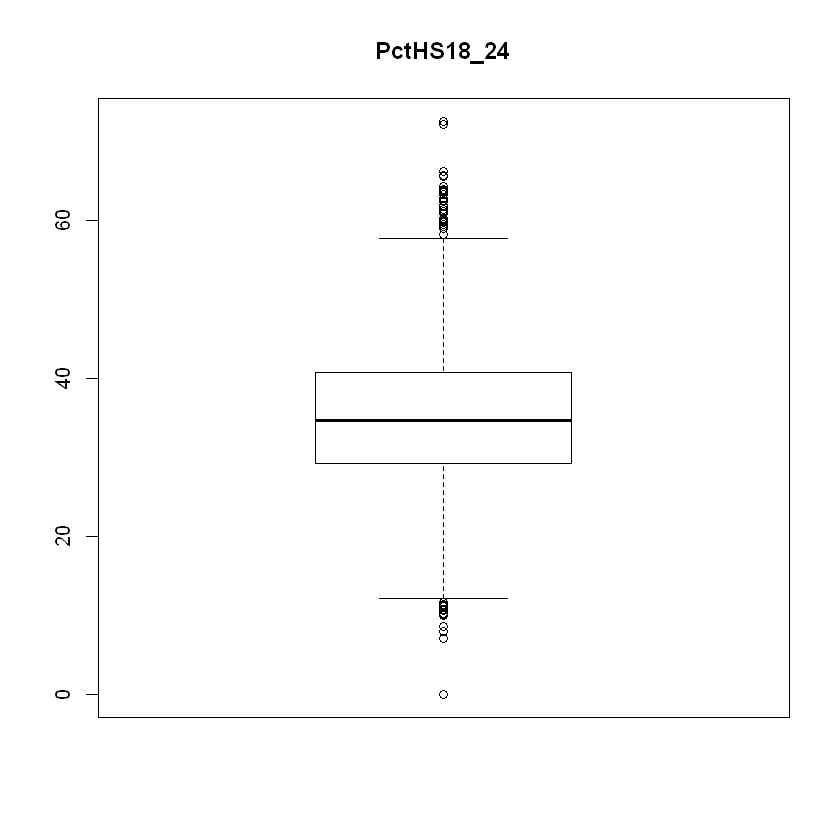

In [3]:
boxplot(data$PctHS18_24, main="PctHS18_24")

4) The parameter "BirthRate" has the minimum value of straight 0, which is suspicious to our experience. We did a box plot just like the one for the parameter "PctHS18_24" to make sure whether this is a singulated extreme value or there are other data points in similar positions. <br>
>As shown in the printed out messages and boxplot below, there is no single cut-off value for 'BirthRate", and therefore we are assuming that the parameter is fine and the data point with straight 0 value might come from a round-off or are some extreme cases in the country

There are 57 points smaller than 2.0
There are 13 points smaller than 1.0
The country with zero birth rate are: 


[1] "De Baca County, New Mexico" "Coke County, Texas"        
[3] "Jeff Davis County, Texas"   "Kinney County, Texas"

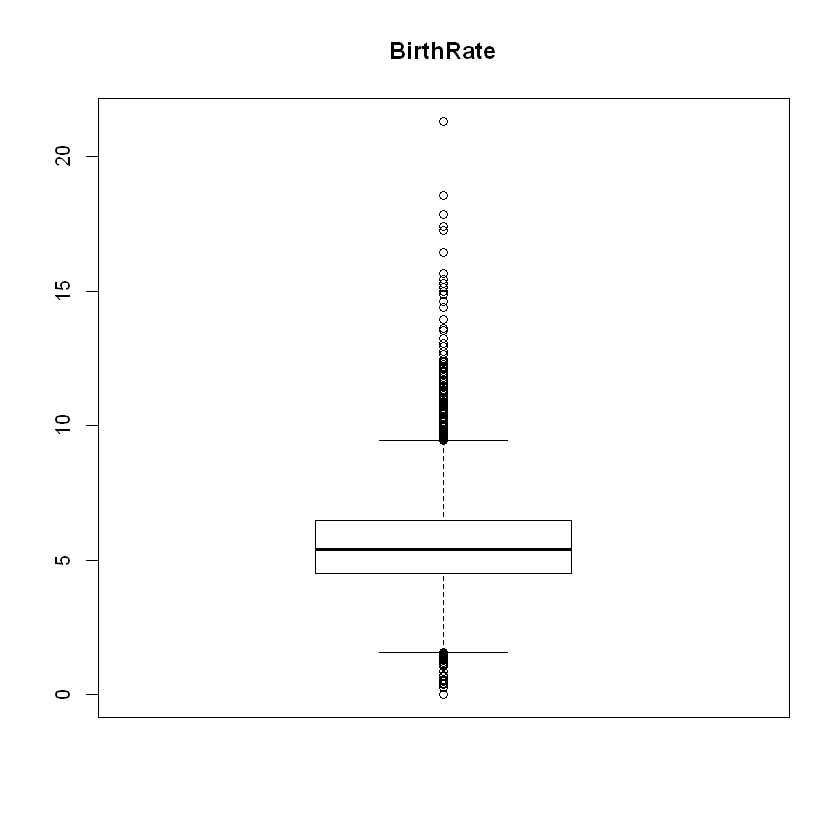

In [21]:
message("There are ",nrow(subset(data,data$BirthRate < 2.0))," points smaller than 2.0")
message("There are ",nrow(subset(data,data$BirthRate < 1.0))," points smaller than 1.0")
message("The country with zero birth rate are: ")
subset(data,data$BirthRate == 0)$Geography
boxplot(data$BirthRate, main="BirthRate")

5) To further check the validity of the dataset, we added up the values from four columns with information on percentage of race distribution across the counties. Our expectation was that the total value should be very close to 100%, if not exactly at 100%. With the printed-out messages and boxplot, we have the following findings and conclusions for the data related to race:<br>
- With the fourth data series being "PctOtherRace", the assumption is that every county should have 100% for "race_total". Considering some small errors in counting and collecting data, 95% should really be the tolerence level for the level of accuracy of these four data columns. 
- However, there are 421 rows of data violating the 95% limit out of the 3047 rows of total data, which accounts of 14% of the total data
- On top of it, there are 24 rows with "race_total" being smaller than 50% and 6 rows smaller than 20%.
- We have serious doubts about the quality of the race statistics, therefore, we are going to try to avoid using the data as we go on with the analysis


The details of data for total race percentage is: 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.23   96.41   97.70   95.99   98.42  100.00 

There are 421 rows of data with total race percentage smaller than 95%
There are 24 rows of data with total race percentage smaller than 50%
There are 6 rows of data with total race percentage smaller than 20%


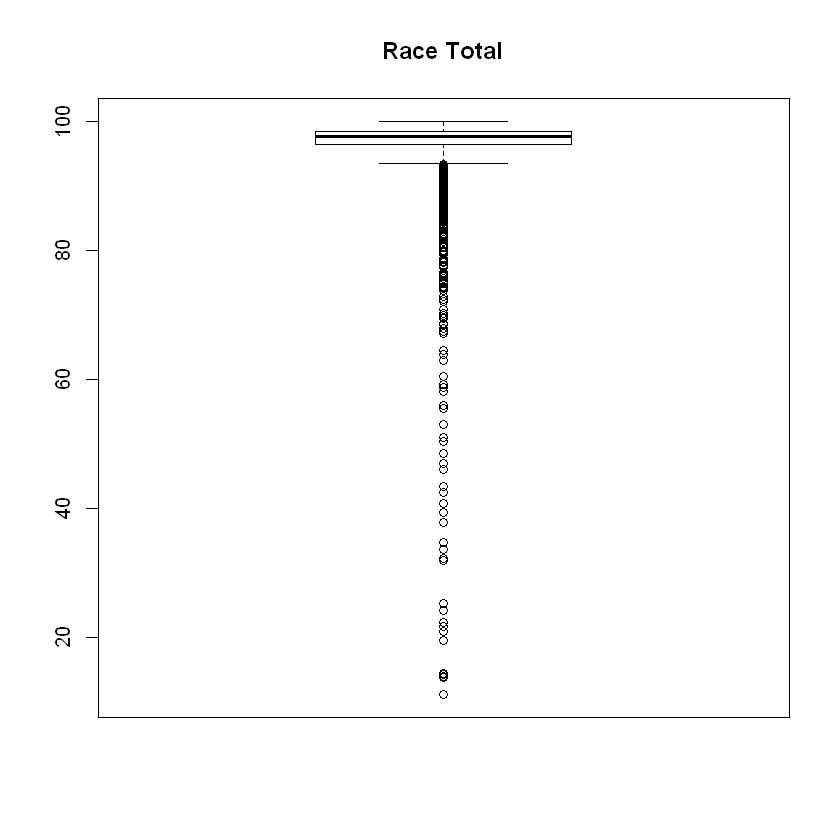

In [22]:
data$total_race <- data$PctAsian + data$PctBlack + data$PctWhite + data$PctOtherRace
message("The details of data for total race percentage is: ")
summary(data$total_race)
message("There are ",nrow(subset(data,data$total_race < 95)), " rows of data with total race percentage smaller than 95%")
message("There are ",nrow(subset(data,data$total_race < 50)), " rows of data with total race percentage smaller than 50%")
message("There are ",nrow(subset(data,data$total_race < 20)), " rows of data with total race percentage smaller than 20%")

boxplot(data$total_race, main = "Race Total")

### Look at the distrubtion of dependent variable "deathRate"

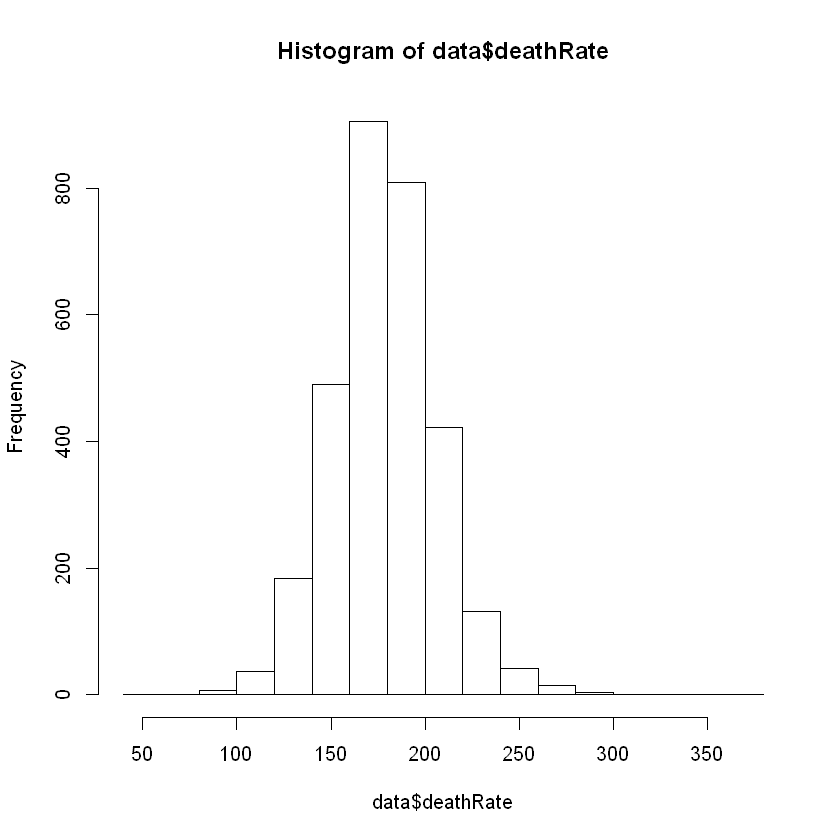

In [23]:
# Look at the distribution of the dependent variable deathRate
hist(data$deathRate)

## this section analyze the common features for counties with higher death rate

In [8]:
# # Split geography information into two different columns, for ease of analysis of location distribution
# # library(stringr)
# data_sub2 <- data.frame(str_split_fixed(data$Geography, ",",2))
# data$County <- data_sub2$X1
# data$State <- data_sub2$X2
# # head(data)


### This is to create another dataframe with deathRate parameter above the third quartile
The objective is to better study the difference between average locations and the counties with much higher deathRate of cancer


In [24]:
deathRatequrt3 <- quantile(data$deathRate,0.75, na.rm=T)
# message(deathRatequrt3)
data_sub1 <- subset(data,data$deathRate > deathRatequrt3)
nrow(data_sub1)

[1] 761

### Sub-question 1: 
how is cancer death rate distributed across the country. Is high death rate concentrated in certain physical regions, or is it of the same pattern across the country

In this comparison, we use the corrplot function (many thanks to John) inside R to have better display of correlation factors between the dataset and the subset. In both charts, color <font color=blue>__blue__</font> represents positive correlation factor while color <font color=red>__red__</font> represents negative correlation. Also, the darker the color and bigger the size of dot represent larger magnitude of the correlation factor

In [10]:
# install.packages("corrplot")

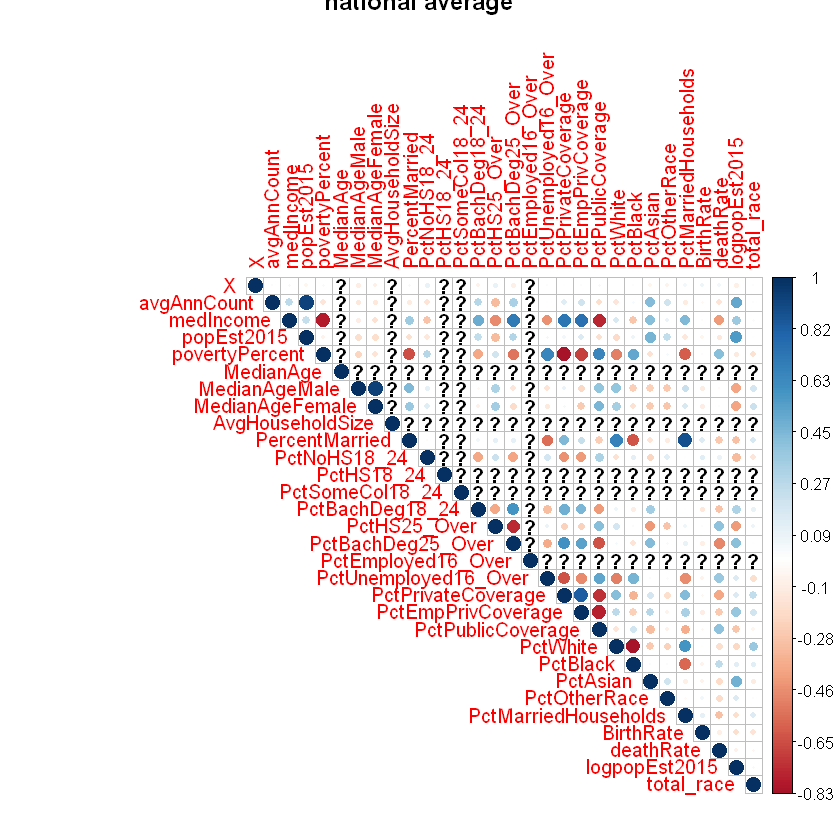

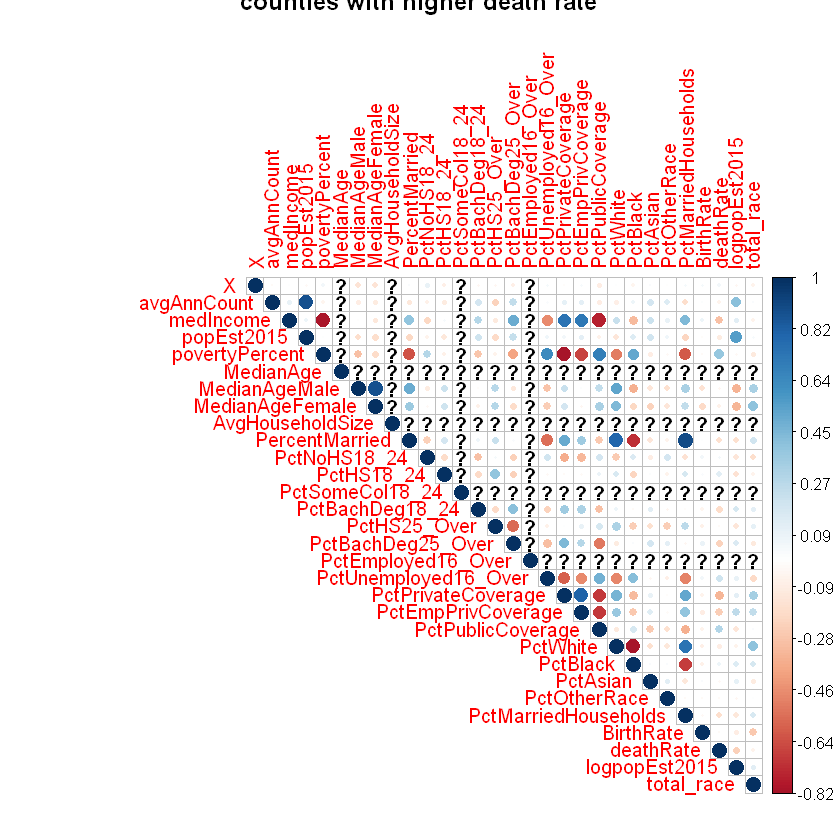

In [25]:
# library(corrplot)
corrplot(cor(data[,sapply(data,is.numeric)]),is.corr=F, method = "circle", type='upper', main = "national average")
corrplot(cor(data_sub1[,sapply(data_sub1,is.numeric)]),is.corr=F, method = "circle", type='upper',main = "counties with higher death rate")

The comparison above shows that the correlations between parameters are not significantly different between the whole data set and the set with higher death rate

__Distribution of higher death rate across the contry__

In [26]:
# library(data.table)
#national average
state_summ <- data.frame(summary(data$state))
names(state_summ) <- c("Counties_total")
# state_summ
state_summ <- setDT(state_summ, keep.rownames = TRUE)[]
# #group with higher death rate
state_summ1 <- data.frame(summary(data_sub1$state))
names(state_summ1) <- c("Counties_total")

state_summ$Counties_highDeathRate <- state_summ1$Counties_total
#Percentage of counties with higher death reate for each state
state_summ$Counties_HDR_Perc <- state_summ$Counties_highDeathRate/state_summ$Counties_total
summary(state_summ[order(state_summ$Counties_HDR_Perc)])
tail(state_summ[order(state_summ$Counties_HDR_Perc)])


      rn            Counties_total   Counties_highDeathRate Counties_HDR_Perc
 Length:51          Min.   :  1.00   Min.   : 0.00          Min.   :0.00000  
 Class :character   1st Qu.: 22.00   1st Qu.: 1.00          1st Qu.:0.02369  
 Mode  :character   Median : 59.00   Median : 5.00          Median :0.12500  
                    Mean   : 59.75   Mean   :14.92          Mean   :0.19028  
                    3rd Qu.: 85.00   3rd Qu.:26.00          3rd Qu.:0.30749  
                    Max.   :233.00   Max.   :91.00          Max.   :0.75833  

rn,Counties_total,Counties_highDeathRate,Counties_HDR_Perc
West Virginia,55,28,0.5090909
Mississippi,82,47,0.5731707
Arkansas,75,44,0.5866667
Louisiana,64,38,0.5937500
Tennessee,95,57,0.6000000
Kentucky,120,91,0.7583333


The analysis above shows that region with higher death rate are not evenly distributed across the country. With huge difference between different states. Kentucky seems to be the one state that really stand out in terms of higher death rate, with 76% of its counties in the high death rate group.To further study the contributing factors to the high cancer death rate in the state of Kentucky, we are looking at a variety of things related to Kentucky. 
<br> Just a quick Google search on the high cancer death rate, there have already been lots of news on high cancer death rate for the state. Also, according to one report, the leading factors are: obesity, smoking and lack of screening. Before we make any further reasoning, we decided to separate the factors that contirbute to causing cancer and those leading to higher death rate. To make that happen, we decided to take a look at how many incidents of cancer occur for those states.

### Sub-question 2: 
before we deepen our analysis on the correlations, we want to answer the first question of which of the two factors lead to the higher cancer death rate.<br>
If the answer to the first question is that high cancer occurance play the most significant role in contributing to higher death rate, we will need more data than the current csv file to back our analysis; however, if the answer is that the treatment support is affecting death rate more, then we will dive into further analysis with our current dataset.<br>

In [27]:
sum_incdt <- data.frame(aggregate(data$avgAnnCount, by=list(Category=data$state),FUN=sum))
names(sum_incdt) <- c("state","total_incident")
sum_incdt <- setDT(sum_incdt, keep.rownames = TRUE)[]
# tail(sum_incdt[order(sum_incdt$total_incident)],20)

#add the total population of state and the incident ratio
sum_pop <- data.frame(aggregate(data$popEst2015, by=list(Category=data$state),FUN=sum))
sum_incdt$popEst <- sum_pop$x
sum_incdt$incdtRatio <- sum_incdt$total_incident/sum_incdt$popEst

# average state-wide death rate
sum_deathRate <- data.frame(aggregate(data$deathRate, by=list(Category=data$state),mean))
sum_incdt$avgDeathRate <- sum_deathRate$x
tail(sum_incdt[order(sum_incdt$incdtRatio)],20)


rn,state,total_incident,popEst,incdtRatio,avgDeathRate
27,Montana,5194.00,1002788,0.005179559,163.1854
10,Florida,105735.00,20222673,0.005228537,179.4303
22,Massachusetts,36128.00,6794422,0.005317303,164.8000
33,New York,105493.00,19795791,0.005329062,171.6403
31,New Jersey,48056.00,8958013,0.005364583,168.6333
36,Ohio,55739.00,10361701,0.005379329,186.8828
23,Michigan,53498.00,9922576,0.005391543,177.8217
16,Iowa,16936.00,3123899,0.005421430,166.4889
8,Delaware,5167.00,945934,0.005462326,178.8667
40,Rhode Island,5880.00,1056298,0.005566611,165.2200


__First__, we try to understand what is the contributing factor to the high death rate due to cancer, whether is the high cancer occurance, or is it the bad cancer treatment. Based on the table above, Kentucky is definitely not the state with the most annual occurance of cancer, at least between 2009 and 2013. In fact, it is not even in the top 20 states with the highest cancer incidents. 
<br>On top of the dataset, we introduced the total population of each state, and calculate the cancer occurance rate based on the population of each state. We re-did the top 20 states with the highest cancer occurance ratio. Kentucky appears in the list as the state with the 10th highest cancer occurance ratio. However, this is still not an alarming status that can make it have the highest cancer death rate without a close second contestant. 
<br>__Secondly__, with the cancer occurance ruled out as the leading factor to high cancer death rate, we went to look at the other factors that contribute to the extreme scenario in Kentucky. The successful treament of cancer is based on a vareity of factors: stage of cancer when screened, health insurance, employment and poverty level, etcs.<br>
### Sub-question 3:
health insurance is directly involved in the quality of cancer treatment, so we want to answer how different types of health insurances are affecting the effectiveness of cancer treatment. <br>

In [28]:
# add to the table above with insurance coverage
# average private coverage by state
sum_PriCov <- data.frame(aggregate(data$PctPrivateCoverage, by=list(Category=data$state),mean))

# average private employed coverage by state
sum_PriEmCov <- data.frame(aggregate(data$PctEmpPrivCoverage, by=list(Category=data$state),mean))
# average public coverage by state
sum_PubCov <- data.frame(aggregate(data$PctPublicCoverage, by=list(Category=data$state),mean))

sum_incdt$Private_Co <- sum_PriCov$x
sum_incdt$PriEm_Co <- sum_PriEmCov$x
sum_incdt$Pub_Co <- sum_PubCov$x

# head(sum_incdt[order(sum_incdt$Private_Co)],10)
# head(sum_incdt[order(sum_incdt$PriEm_Co)],10)
# tail(sum_incdt[order(sum_incdt$Pub_Co)],10)
message("Private Converage")
summary(sum_incdt$Private_Co)
message("Private Employer coverage")
summary(sum_incdt$PriEm_Co)
message("Public Converage")
summary(sum_incdt$Pub_Co)
tail(sum_incdt[order(sum_incdt$avgDeathRate)],10)
head(sum_incdt[order(sum_incdt$avgDeathRate)],5)




Private Converage


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  52.00   60.40   65.20   65.63   71.78   77.63 

Private Employer coverage


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.83   37.40   41.91   42.57   48.09   54.29 

Public Converage


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  25.00   32.53   35.42   35.91   39.54   45.51 

rn,state,total_incident,popEst,incdtRatio,avgDeathRate,Private_Co,PriEm_Co,Pub_Co
26,Missouri,30939,6083672,0.005085580,189.6948,63.16348,40.07913,36.47478
1,Alabama,24182,4750529,0.005090380,192.7286,61.48571,38.48730,39.32063
2,Alaska,2512,706895,0.003553569,193.4167,56.79444,39.77222,28.75000
37,Oklahoma,18555,3911338,0.004743901,193.9494,59.65325,37.29481,36.38052
49,West Virginia,11130,1844128,0.006035373,196.7109,60.77636,40.61273,42.84364
19,Louisiana,23242,4670724,0.004976102,197.6734,57.03906,37.90000,37.36250
4,Arkansas,14762,2978204,0.004956679,200.0907,54.35333,33.29867,44.21467
43,Tennessee,33284,6600299,0.005042802,200.8758,60.56737,38.53684,39.93895
25,Mississippi,15007,2992333,0.005015150,202.8378,52.56707,34.20122,41.98049
18,Kentucky,24765,4425092,0.005596494,215.3158,59.02000,39.64833,41.30083


rn,state,total_incident,popEst,incdtRatio,avgDeathRate,Private_Co,PriEm_Co,Pub_Co
45,Utah,9190,2993293,0.003070197,135.7519,70.95926,50.29259,25.00370
6,Colorado,21001,5453017,0.003851263,141.5617,62.87000,38.96833,34.56000
12,Hawaii,6617,1431514,0.004622379,142.9750,72.05000,48.87500,33.60000
3,Arizona,27051,6828065,0.003961737,149.0867,54.80000,32.51333,43.96667
13,Idaho,7221,1652984,0.004368463,154.2024,63.70238,37.23333,33.71190


The summary and table above show the state wide percentage of health insurance coverage of different types. the table above is ranked by total death rate from cancer. We can draw the following conclusions from the table above:<br>
- all states have private insurance coverage percentage lower than the national median, and with most lower than the first quartile
- the situation is similar with private employer provided coverage
- all the states in the top ten list have public health insurance coverage percentage higher than the national median, and with most higher than the third quartile. However, besides state Arkansas, they are not as high as the national maximum<br>

<br>From the above analysis, we see that states with higher cancer death rate tend to have very low percentage of private insurance coverage. From the opposite end, we see that states with lowest cancer death rate have:<br>
- very high private insurance coverage, relatively high private employer coverage and relatively low public coverage

<br> Based on the analysis above, we have the reason to believe that having higher coverage from private insurance providers seem to have better cancer treatment rate. Therefore, in the following analysis, we are looking at the employment rate and income for the states with higher cancer death rate

In [29]:
sum_PovPerc <- data.frame(aggregate(data$povertyPercent, by=list(Category=data$state),mean))

# average private employed coverage by state
sum_income <- data.frame(aggregate(data$medIncome, by=list(Category=data$state),mean))
# average public coverage by state
sum_Employed <- data.frame(aggregate(data$PctEmployed16_Over, by=list(Category=data$state),mean, na.rm = T))

sum_incdt$PovPerc <- sum_PovPerc$x
sum_incdt$income <- sum_income$x
sum_incdt$Employed <- sum_Employed$x

message("Poverty Percentage")
summary(sum_incdt$PovPerc)
message("median income")
summary(sum_incdt$income)
message("Percentage Employed")
summary(sum_incdt$Employed)

tail(sum_incdt[order(sum_incdt$avgDeathRate)],10)


Poverty Percentage


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  9.838  12.685  15.081  15.875  18.625  25.399 

median income


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  35659   43438   50044   50575   55450   72135 

Percentage Employed


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  45.37   50.50   55.72   55.38   60.64   63.81 

rn,state,total_incident,popEst,incdtRatio,avgDeathRate,Private_Co,PriEm_Co,Pub_Co,PovPerc,income,Employed
26,Missouri,30939,6083672,0.005085580,189.6948,63.16348,40.07913,36.47478,17.97652,41522.63,53.35000
1,Alabama,24182,4750529,0.005090380,192.7286,61.48571,38.48730,39.32063,21.94286,38871.13,47.92167
2,Alaska,2512,706895,0.003553569,193.4167,56.79444,39.77222,28.75000,13.89444,63487.78,60.68125
37,Oklahoma,18555,3911338,0.004743901,193.9494,59.65325,37.29481,36.38052,17.68961,43818.78,53.37867
49,West Virginia,11130,1844128,0.006035373,196.7109,60.77636,40.61273,42.84364,19.34909,39391.80,46.63333
19,Louisiana,23242,4670724,0.004976102,197.6734,57.03906,37.90000,37.36250,22.24063,41705.95,49.84407
4,Arkansas,14762,2978204,0.004956679,200.0907,54.35333,33.29867,44.21467,21.34133,37577.95,49.24648
43,Tennessee,33284,6600299,0.005042802,200.8758,60.56737,38.53684,39.93895,19.73053,40645.47,49.71000
25,Mississippi,15007,2992333,0.005015150,202.8378,52.56707,34.20122,41.98049,25.39878,35659.48,47.12785
18,Kentucky,24765,4425092,0.005596494,215.3158,59.02000,39.64833,41.30083,21.85333,39687.22,48.62768


Based on the summaries and table above, we can draw the following conclusions:<br>
- states with higher cancer death rate tend to have higher poverty level, with the exception of state Alaska. Almost all of them above the national median, with the exception of state virginia, and most close to or above the third quartile
- besides the exception of Alaska, the median incomes across the state are all lower than national median and most between national minimum and first quartile
- the story is pretty much the same for percentage of people employed


## Conclusion

We have seen some pattern that lower income and lower employment rate are contributing to smaller percentage of private insurance coverage, which seem to have led to worse cancer treatment and higher death rate from cancer.<br>

The study shows strong correlation between cancer death rate and the percentage of private insurance coverage. The fact that almost all the states within top ten list of high cancer death rate fall into the lowest quartile of private insurance coverage is strong evidence that the private insurance coverage can contribute to better cancer treatment. to dig out the factor why private coverage is better, we would need to find data of other sources, which could be the next step for this study.

Also, it does not mean that public coverage does not fulfill the job. There are exceptions that states with higher public coverage also have lower cancer death rate. The reason could be the better facilities or cancer research centers specific to those states. the next step could be to find the differences in public coverage between different states, and how effective they are in minimizing cancer death rate.